In [242]:
#--- Instalación de las librerias necesarias

!pip install corner

In [243]:
#--- Carga de las librerias y los datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import corner

data = pd.read_csv('Cars93.csv')

In [244]:
#--- Visualización de las columnas y los datos cuantificables

data.head()

,Unnamed: 0,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,4,1.8,140,6300,2890,Yes,13.2,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,3.2,200,5500,2335,Yes,18.0,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,2.8,172,5500,2280,Yes,16.9,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,Driver & Passenger,Front,6,2.8,172,5500,2535,Yes,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,3.5,208,5700,2545,Yes,21.1,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


In [245]:
#--- Escogencia de las variables significativas
#    Por conocimiento a priori, se escogen claramente la marca, el tamaño y aspectos cuantitativos como los caballos de fuerza, millas por galón, etc, como
#    las variables a tomar en cuenta.

keys = ['Manufacturer', 'Type', 'MPG.city', 'MPG.highway', 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity', 'Weight', 'Length', 'Wheelbase', 'Width', 'Turn.circle']
y = 'Price'

In [246]:
#--- Existencia de datos nulos

np.sum(pd.isnull(data[keys]))

Manufacturer          0
Type                  0
MPG.city              0
MPG.highway           0
EngineSize            0
Horsepower            0
RPM                   0
Rev.per.mile          0
Fuel.tank.capacity    0
Weight                0
Length                0
Wheelbase             0
Width                 0
Turn.circle           0
dtype: int64

In [247]:
#--- Se revisa la unicidad de las llaves 'Manufacturer' y 'Type' y se crean los diccionarios para tomar valores cuantitativos.

np.unique(data['Manufacturer'], return_counts=True)

(array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
        'Chrylser', 'Chrysler', 'Dodge', 'Eagle', 'Ford', 'Geo', 'Honda',
        'Hyundai', 'Infiniti', 'Lexus', 'Lincoln', 'Mazda',
        'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile',
        'Plymouth', 'Pontiac', 'Saab', 'Saturn', 'Subaru', 'Suzuki',
        'Toyota', 'Volkswagen', 'Volvo'], dtype=object),
 array([2, 2, 1, 4, 2, 8, 1, 2, 6, 2, 8, 2, 3, 4, 1, 2, 2, 5, 2, 2, 2, 4,
        4, 1, 5, 1, 1, 3, 1, 4, 4, 2]))

In [248]:
np.unique(data['Type'], return_counts=True)

(array(['Compact', 'Large', 'Midsize', 'Small', 'Sporty', 'Van'],
       dtype=object), array([16, 11, 22, 21, 14,  9]))

In [249]:
#--- Debido a la gran cantidad de datos distintos y la poca repetición de estos en 'Manufacturer', se evita utilizar esta llave para el algoritmo.

keys = ['Type', 'MPG.city', 'MPG.highway', 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity', 'Weight', 'Length', 'Wheelbase', 'Width', 'Turn.circle']

In [250]:
#--- Creamos el diccionario para traducir 'Type' a variables cuantitativas y creamos la nueva columna 'TypeN' con estos valores

types = {}
unique_types = np.unique(data['Type'])
for i in range(len(unique_types)):
  types[unique_types[i]] = i

data['TypeN'] = [types[x] for x in data['Type']] 
keys = ['TypeN', 'MPG.city', 'MPG.highway', 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity', 'Weight', 'Length', 'Wheelbase', 'Width', 'Turn.circle']

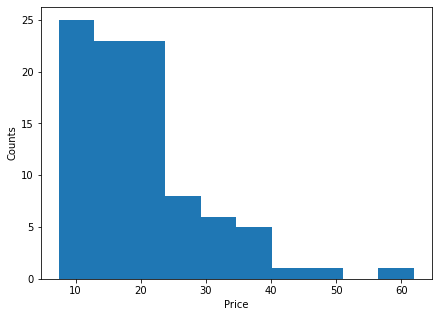

In [251]:
#--- Visualizamos el objetivo

plt.figure(figsize=(7,5))
plt.hist(data[y])
plt.xlabel('Price')
plt.ylabel('Counts')
plt.show()

In [252]:
#--- Creamos 3 intervalos de tiempo de tal forma que intentemos, manualmente, que estos estén balanceados

Y = np.array(data[y], dtype=int)

Y[Y<14] = 1                 #Precio bajo
Y[(14<=Y)&(Y<20)] = 2       #Precio intermedio
Y[20<=Y] = 3                #Precio alto

np.unique(Y, return_counts=True)

(array([1, 2, 3]), array([29, 32, 32]))

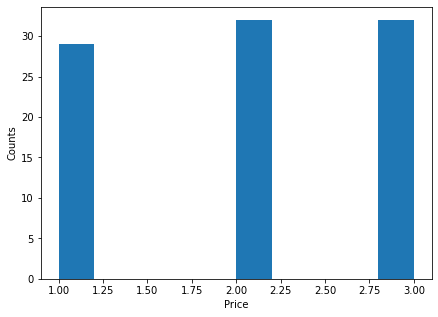

In [253]:
#--- Visualizamos nuevamente el objetivo ya balanceado

plt.figure(figsize=(7,5))
plt.hist(Y)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.show()

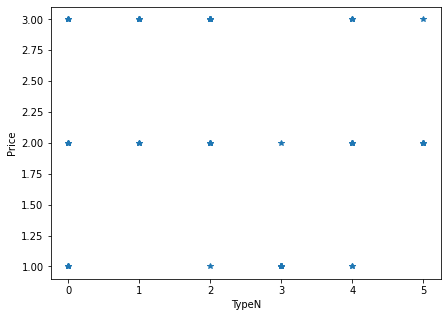

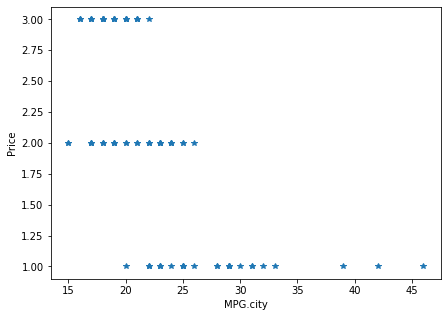

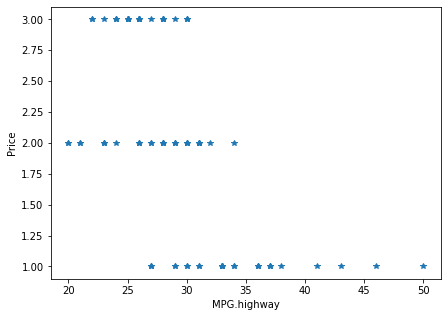

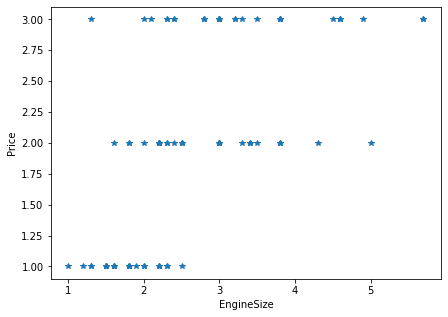

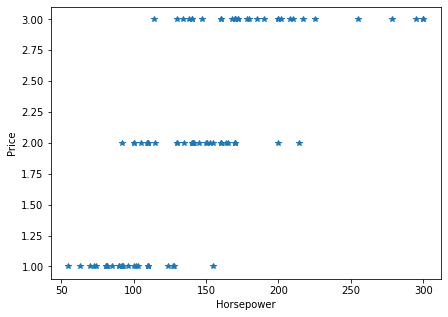

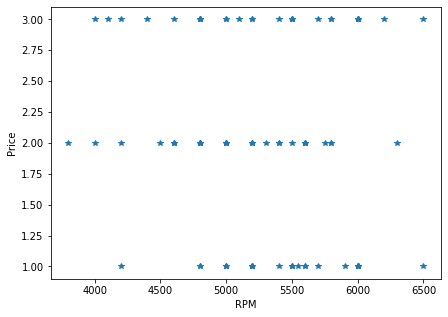

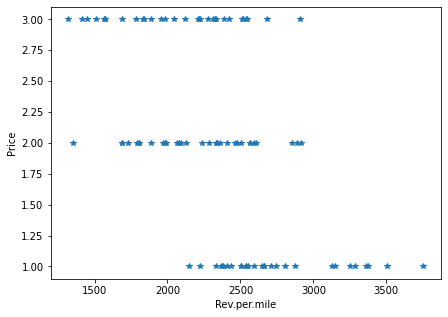

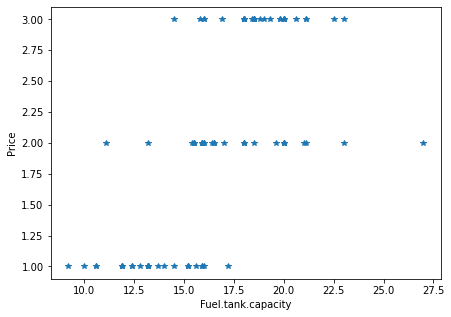

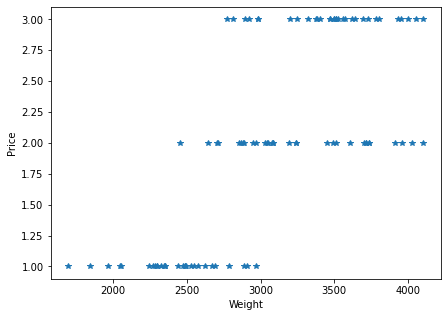

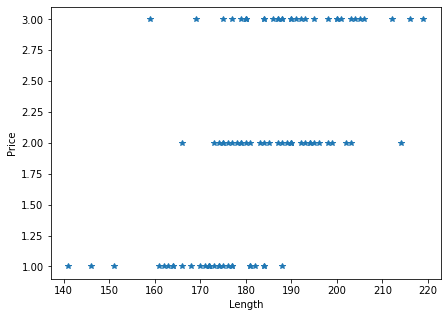

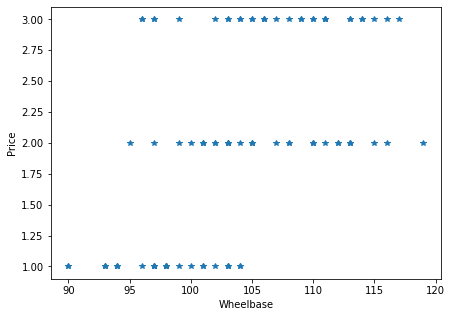

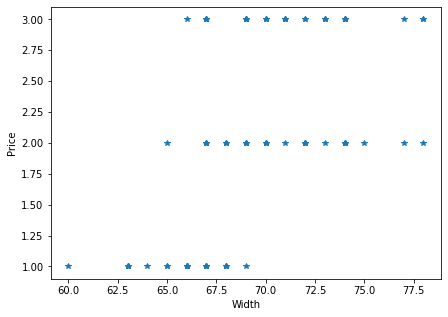

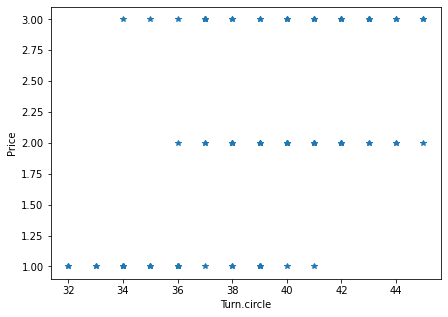

In [254]:
#--- Realizamos una clasificación visual de los datos y el precio

for k in keys:
  fig = plt.figure(figsize=(7,5))
  plt.plot(data[k],Y,'*')
  plt.xlabel(k)
  plt.ylabel('Price')
  plt.show()

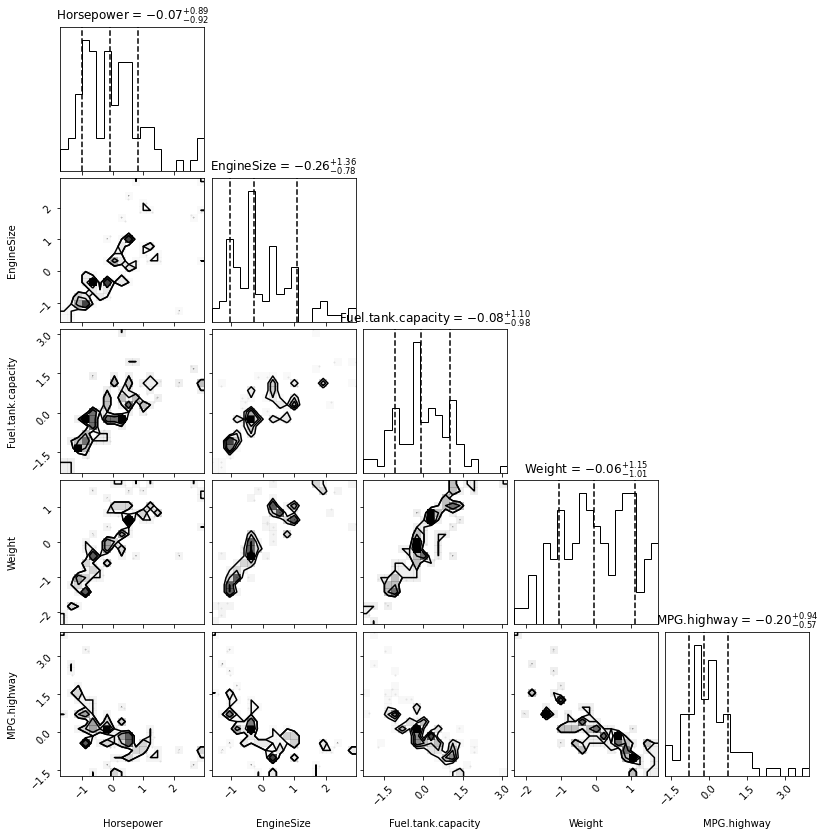

In [255]:
#--- De los datos anteriores, podemos hipotetizar que las variables que más afectan el costo son, sin orden específico, Horsepower, EngineSize, Fuel.tank.capacity, MPG.highway y Weight.
#    Podemos ahora normalizar los datos y realizar un análisis de correlaciones buscando que sean, en general, independientes entre sí.

data_scaled = StandardScaler().fit_transform(data[keys])
keys_hip = np.array(['Horsepower', 'EngineSize', 'Fuel.tank.capacity', 'Weight', 'MPG.highway'])

data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = keys

figure = corner.corner(data_scaled[keys_hip], labels=keys_hip,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [256]:
#-- Donde vemos que, lastimosamente, existe una correlación entre practicamente todas las variables importantes hipotetizadas. Sin embargo, por este mismo motivo, 
#   no podemos descartar ninguna.
#   Empezamos ahora con el análisis de ML por el método de bosque aleatorio.

model = RandomForestClassifier(n_estimators=100, max_depth=10)
X_train, X_test, Y_train, Y_test = train_test_split(np.array(data_scaled[keys]), Y)
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

In [257]:
#-- Calculamos la precisión

acc = sum(Y_pred == Y_test)/len(Y_test)
acc

0.875

In [258]:
#-- Calculamos la importancia de los parametros

importances = model.feature_importances_
importances

array([0.05829045, 0.1009642 , 0.08410524, 0.06724856, 0.12310128,
       0.04813735, 0.06787257, 0.1145582 , 0.13248549, 0.03970459,
       0.04054385, 0.07768058, 0.04530765])

In [259]:
#--- Y finalmente organizamos los parametros de menor a mayor

ii = np.argsort(importances)[::-1]
np.array(keys)[ii]

array(['Weight', 'Horsepower', 'Fuel.tank.capacity', 'MPG.city',
       'MPG.highway', 'Width', 'Rev.per.mile', 'EngineSize', 'TypeN',
       'RPM', 'Turn.circle', 'Wheelbase', 'Length'], dtype='<U18')

In [260]:
#-- Finalmente concluimos un aprendizaje de alta exactitud en donde se concluyó que las variables más importantes para determinar el precio de un auto son Weight y Horsepower,
#   las cuales hacen parte y apoyan la hipótesis que habíamos formulado.